In [1]:
import time

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
import uproot

from awkward import JaggedArray
import numpy as np
import pickle

import matplotlib.pyplot as plt
from matplotlib import ticker,colors

In [2]:
from utils.fileList_AnalysisNtuples2016 import fileset2016, fileset_Data2016, filesetTest2016
from utils.fileList_AnalysisNtuples2017 import fileset2017, fileset_Data2017
from utils.fileList_AnalysisNtuples2018 import fileset2018, fileset_Data2018


In [3]:
datasetOrder={"$t\overline{t}+\gamma \;(1\ell)$":["TTGamma1l"],
              "$t\overline{t}+\gamma \;(2\ell)$":["TTGamma2l"],
              "$t\overline{t}+\gamma \;(0\ell)$":["TTGamma0l"],
              "$t\overline{t} \;(1\ell)$":["TTbar1l"],
              "$t\overline{t} \;(2\ell)$":["TTbar2l"],
              "$t\overline{t} \;(0\ell)$":["TTbar0l"],
              "Single top":["ST"],
              "W+jets":["Wjets"],
              "Z+jets":["DY"],
              "$W+\gamma$":["WGamma"],
              "$Z+\gamma$":["ZGamma"],
              "Other":["Diboson",
                       "TTV",
                       "QCD"],
             }

categoryDataEle = {"Data":["DataA_Ele",
                           "DataB_Ele",
                           "DataC_Ele",
                           "DataD_Ele",
                           "DataE_Ele",
                           "DataF_Ele",
                           "DataG_Ele",
                           "DataH_Ele"]}

categoryDataMu  = {"Data":["DataA_Mu",
                           "DataB_Mu",
                           "DataC_Mu",
                           "DataD_Mu",
                           "DataE_Mu",
                           "DataF_Mu",
                           "DataG_Mu",
                           "DataH_Mu"]}


categoryData    = {"Data":["DataA_Ele",
                           "DataB_Ele",
                           "DataC_Ele",
                           "DataD_Ele",
                           "DataE_Ele",
                           "DataF_Ele",
                           "DataG_Ele",
                           "DataH_Ele",
                           "DataA_Mu",
                           "DataB_Mu",
                           "DataC_Mu",
                           "DataD_Mu",
                           "DataE_Mu",
                           "DataF_Mu",
                           "DataG_Mu",
                           "DataH_Mu"]}

In [4]:
# Look at ProcessorABC to see the expected methods and what they are supposed to do
class TTGammaProcessor(processor.ProcessorABC):
#     def __init__(self, runNum = -1, eventNum = -1):
    def __init__(self, runNum = -1, eventNum = -1, mcEventYields = None):
#        dataset_axis = hist.Cat("dataset", "Dataset",sorting='placement')
#        dataset_axis = hist.Cat("dataset", "Dataset",sorting='integral')
        dataset_axis = hist.Cat("dataset", "Dataset",sorting='identifier')
        MET_axis = hist.Bin("MET", r"$MET$ [GeV]", 1000, 0., 1000)
        M3_axis = hist.Bin("M3", r"$M_{3}$ [GeV]", 1000, 0., 1000)
        MT_axis = hist.Bin("MT", r"$M_{T}$ [GeV]", 1000, 0., 1000)
        pt_axis = hist.Bin("pt", r"$p_{T}$ [GeV]", 1000, 0., 1000)
        phi_axis = hist.Bin("phi", r"$\phi$", np.arange(-3.2, 3.2001,0.05))
        eta_axis = hist.Bin("eta", r"$\eta$", np.arange(-3, 3.0001,0.05))
        lep_axis = hist.Cat("lepton", r"lepton")
        year_axis = hist.Cat("year", r"year")
        
        pho_axis = hist.Bin("nPho", r"# of photons",np.arange(0,2.1,1))
        jet_axis = hist.Bin("nJet", r"# of jets",np.arange(0,8.1,1))
        bjet_axis = hist.Bin("nBJet", r"# of bjets",np.arange(0,4.1,1))

        
        self._accumulator = processor.dict_accumulator({
            ##photon histograms
            'elePt' : hist.Hist("Counts", dataset_axis, pt_axis,pho_axis,jet_axis,bjet_axis),
            'eleEta': hist.Hist("Counts", dataset_axis, eta_axis,pho_axis,jet_axis,bjet_axis),
            'elePhi': hist.Hist("Counts", dataset_axis, phi_axis,pho_axis,jet_axis,bjet_axis),

            'muPt' : hist.Hist("Counts", dataset_axis, pt_axis,pho_axis,jet_axis,bjet_axis),
            'muEta': hist.Hist("Counts", dataset_axis, eta_axis,pho_axis,jet_axis,bjet_axis),
            'muPhi': hist.Hist("Counts", dataset_axis, phi_axis,pho_axis,jet_axis,bjet_axis),
            
            'jetPt' : hist.Hist("Counts", dataset_axis, pt_axis,lep_axis),
            'jetEta': hist.Hist("Counts", dataset_axis, eta_axis,lep_axis),
            'jetPhi': hist.Hist("Counts", dataset_axis, phi_axis,lep_axis),

            'phoPt' : hist.Hist("Counts", dataset_axis, pt_axis,lep_axis,jet_axis,bjet_axis),
            'phoEta': hist.Hist("Counts", dataset_axis, eta_axis,lep_axis,jet_axis,bjet_axis),
            'phoPhi': hist.Hist("Counts", dataset_axis, phi_axis,lep_axis,jet_axis,bjet_axis),
            
            'MET' : hist.Hist("Counts", dataset_axis, MET_axis,lep_axis,pho_axis,jet_axis,bjet_axis),
            'M3' : hist.Hist("Counts", dataset_axis, M3_axis,lep_axis,pho_axis,jet_axis,bjet_axis),
            'WtransMass' : hist.Hist("Counts", dataset_axis, MT_axis,lep_axis,pho_axis,jet_axis,bjet_axis),
        })

        
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()
        
        datasetFull = df['dataset']
        dataset = datasetFull[:-5]
        year = int(datasetFull[-4:])
        
        
        nJet = df['nJet']
        nBJet = df['nBJet']
        passEle = df['passPresel_Ele']
        passMu = df['passPresel_Mu']

        electrons = JaggedCandidateArray.candidatesfromcounts(        
            df['nEle'],
            pt = df['elePt'],
            eta = df['eleSCEta'],
            phi = df['elePhi'],
            mass = np.zeros_like(df['elePt']),
        )
            
        muons = JaggedCandidateArray.candidatesfromcounts(        
            df['nMu'],
            pt = df['muPt'],
            eta = df['muEta'],
            phi = df['muPhi'],
            mass = np.zeros_like(df['muPt']),
        )
            
        jets = JaggedCandidateArray.candidatesfromcounts(        
            df['nJet'],
            pt = df['jetPt'],
            eta = df['jetEta'],
            phi = df['jetPhi'],
            mass = np.zeros_like(df['jetPt']),
        )

        photons = JaggedCandidateArray.candidatesfromcounts(        
            df['nPho'],
            pt = df['phoEt'],
            eta = df['phoEta'],
            phi = df['phoPhi'],
            mass = np.zeros_like(df['phoEt']),
        )
            
            
        
        selectionEle = (passEle
                        & (nJet>=4)
                        & (nBJet>=1))

        selectionMu = (passMu
                        & (nJet>=4)
                        & (nBJet>=1))
        
        
        ##Only select electron events from SingleEle dataset, and muons from SingleMu, to avoid double counting
        if 'Data' in dataset:
            if 'Ele' in dataset:
                selectionMu=np.zeros_like(selectionMu)
            if 'Mu' in dataset:
                selectionEle=np.zeros_like(selectionEle)
        
        selectionElePho = selectionEle & (photons.counts==1)
        selectionMuPho  = selectionMu & (photons.counts==1)
        
        weight = df['evtWeight']*df['PUweight']*df['muEffWeight']*df['eleEffWeight']

        ### btagging weights need to be fixed
        ### currently method 1c is used in analysisNtuples, which are difficult for splitting by number of b-tags
        ### new ntuples will have method 1a in them, which will work better
#         btagWeight = 1.-df['btagWeight'][::3]
#         weight *= btagWeight

        if 'Data' in dataset:
            weight= np.ones_like(df['nJet'])

        output['elePt'].fill(dataset=dataset,
                             year=year,
                             pt=electrons.pt[passEle].flatten(),
                             nPho=df['nPho'][passEle].flatten(),
                             nJet=df['nJet'][passEle].flatten(),
                             nBJet=df['nBJet'][passEle].flatten(),
                             weight=weight[passEle].flatten()
                            )
        output['eleEta'].fill(dataset=dataset,
                              year=year,
                              eta=electrons.eta[passEle].flatten(),
                              nPho=df['nPho'][passEle].flatten(),
                              nJet=df['nJet'][passEle].flatten(),
                              nBJet=df['nBJet'][passEle].flatten(),
                              weight=weight[passEle].flatten()
                             )
        output['elePhi'].fill(dataset=dataset,
                              year=year,
                              phi=electrons.phi[passEle].flatten(),
                              nPho=df['nPho'][passEle].flatten(),
                              nJet=df['nJet'][passEle].flatten(),
                              nBJet=df['nBJet'][passEle].flatten(),
                              weight=weight[passEle].flatten()
                              )

        output['muPt'].fill(dataset=dataset,
                              year=year,
                             pt=muons.pt[passMu].flatten(),
                             nPho=df['nPho'][passMu].flatten(),
                             nJet=df['nJet'][passMu].flatten(),
                             nBJet=df['nBJet'][passMu].flatten(),
                             weight=weight[passMu].flatten()
                            )
        output['muEta'].fill(dataset=dataset,
                              year=year,
                              eta=muons.eta[passMu].flatten(),
                              nPho=df['nPho'][passMu].flatten(),
                              nJet=df['nJet'][passMu].flatten(),
                              nBJet=df['nBJet'][passMu].flatten(),
                              weight=weight[passMu].flatten()
                             )
        output['muPhi'].fill(dataset=dataset,
                              year=year,
                              phi=muons.phi[passMu].flatten(),
                              nPho=df['nPho'][passMu].flatten(),
                              nJet=df['nJet'][passMu].flatten(),
                              nBJet=df['nBJet'][passMu].flatten(),
                              weight=weight[passMu].flatten()
                              )
        
#         output['M3'].fill(dataset=dataset,
#                           lepton="electron",
#                           M3=df['M3'][selectionEle].flatten(),
#                           weight=weight[selectionEle].flatten()
#                          )




        for lepton,selection in [['muon',passMu],['electron',passEle]]:
        
            output['M3'].fill(dataset=dataset,
                              lepton=lepton,
                              year=year,
                              M3=df['M3'][selection].flatten(),
                              nPho=df['nPho'][selection].flatten(),
                              nJet=df['nJet'][selection].flatten(),
                              nBJet=df['nBJet'][selection].flatten(),
                              weight=weight[selection].flatten()
                             )
            output['WtransMass'].fill(dataset=dataset,
                              lepton=lepton,
                              year=year,
                              MT=df['WtransMass'][selection].flatten(),
                              nPho=df['nPho'][selection].flatten(),
                              nJet=df['nJet'][selection].flatten(),
                              nBJet=df['nBJet'][selection].flatten(),
                              weight=weight[selection].flatten()
                             )
            output['phoPt'].fill(dataset=dataset,
                                 lepton=lepton,
                                 year=year,
                                 pt=photons.pt[selection & (photons.counts==1)].flatten(),
                                 nJet=df['nJet'][selection & (photons.counts==1)].flatten(),
                                 nBJet=df['nBJet'][selection & (photons.counts==1)].flatten(),
                                 weight=weight[selection & (photons.counts==1)].flatten()
                                )
            output['phoEta'].fill(dataset=dataset,
                                  lepton=lepton,
                                  year=year,
                                  nJet=df['nJet'][selection & (photons.counts==1)].flatten(),
                                  nBJet=df['nBJet'][selection & (photons.counts==1)].flatten(),
                                  eta=photons.eta[selection & (photons.counts==1)].flatten(),
                                  weight=weight[selection & (photons.counts==1)].flatten()
                                 )
            output['phoPhi'].fill(dataset=dataset,
                                  lepton=lepton,
                                  year=year,
                                  phi=photons.phi[selection & (photons.counts==1)].flatten(),
                                  nJet=df['nJet'][selection & (photons.counts==1)].flatten(),
                                  nBJet=df['nBJet'][selection & (photons.counts==1)].flatten(),
                                  weight=weight[selection & (photons.counts==1)].flatten()
                                 )

        
#         output['phoPt'].fill(dataset=dataset,
#                              lepton="muon",
#                               year=year,
#                              pt=photons.pt[selectionMuPho].flatten(),
#                              weight=weight[selectionMuPho].flatten()
#                             )
#         output['phoEta'].fill(dataset=dataset,
#                              lepton="muon",
#                               year=year,
#                              eta=photons.eta[selectionMuPho].flatten(),
#                              weight=weight[selectionMuPho].flatten()
#                             )
#         output['phoPhi'].fill(dataset=dataset,
#                              lepton="muon",
#                               year=year,
#                              phi=photons.phi[selectionMuPho].flatten(),
#                              weight=weight[selectionMuPho].flatten()
#                             )

        
        return output

    def postprocess(self, accumulator):
        return accumulator
        
        

In [5]:
lumi = 35.9
fileset = fileset2016
#fileset = filesetTest2016

output = processor.run_uproot_job(fileset,
                                  treename='AnalysisTree',
                                  processor_instance=TTGammaProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 8, 'flatten': True},
                                 
#                                   chunksize=50000,                                                                                          
#                                   maxchunks=0                                                                                              

                                 )

Processing: 100%|██████████| 172/172 [03:04<00:00,  1.07s/items]


In [6]:
fileset_Data = fileset_Data2016

outputData = processor.run_uproot_job(fileset_Data,
                                  treename='AnalysisTree',
                                  processor_instance=TTGammaProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 8, 'flatten': True},
                                 
#                                   chunksize=50000,
#                                   maxchunks=0                                                                                              

                                 )

#dataCategory = {"Data":list(fileset_Data.keys())}

Processing: 100%|██████████| 62/62 [01:06<00:00,  1.07s/items]


In [7]:
from utils.plotting import plotWithRatio

In [8]:
blues = ['#2171b5','#9ecae1','#08306b']
reds = ['#ef3b2c','#fc9272','#a50f15']
greens = ['#41ae76','#99d8c9','#006d2c']

colors = blues + reds + greens + ['#fec44f','#cc4c02','#807dba','#54278f','#8c510a']


/uscms/home/dnoonan/.local/lib/python3.6/site-packages/coffea/hist/hist_tools.py:337: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f165bcaca90>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/uscms_data/d2/dnoonan/13TeV_TTGamma/NanoAODTest/Coffea_TTGamma/utils/plotting.py:129: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0,ax.get_ylim()[1]*1.1)


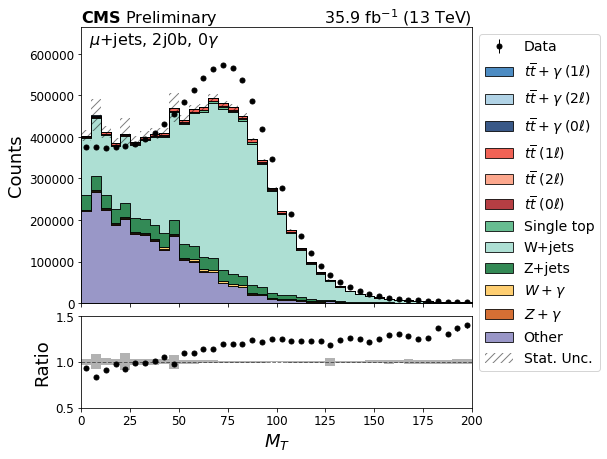

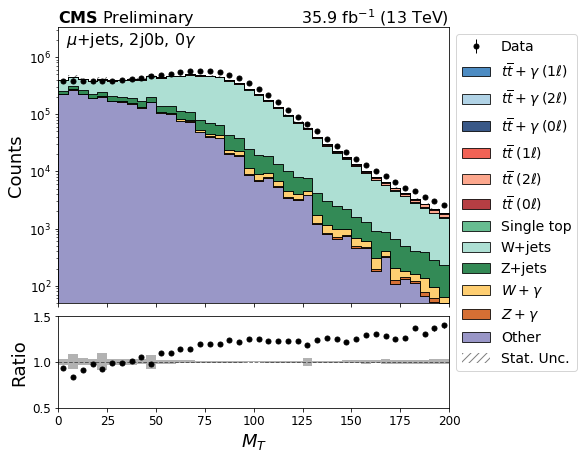

In [9]:
h = output['WtransMass'].integrate('lepton','muon').group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder)
h = h.rebin('MT',hist.Bin('MT','$M_{T}$',np.arange(0,200.1,5)))
h = h.integrate('nPho',0).integrate('nJet',2).integrate('nBJet',0)
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['WtransMass'].integrate('lepton','muon').group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData)
hData = hData.rebin('MT',hist.Bin('MT','$M_{T}$',np.arange(0,200.1,5)))
hData = hData.integrate('nPho',0).integrate('nJet',2).integrate('nBJet',0)


test = plotWithRatio(h,hData,'dataset', lumi=lumi, 
                     extraText="$\mu$+jets, 2j0b, 0$\gamma$",colors=colors
                    )

test = plotWithRatio(h,hData,'dataset', lumi=lumi, 
                     extraText="$\mu$+jets, 2j0b, 0$\gamma$",colors=colors,logY=True,
                     xRange=(0,None),
                     yRange=(50,3e6),
                    )

/uscms/home/dnoonan/.local/lib/python3.6/site-packages/coffea/hist/hist_tools.py:337: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f165bcaca90>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/uscms_data/d2/dnoonan/13TeV_TTGamma/NanoAODTest/Coffea_TTGamma/utils/plotting.py:129: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0,ax.get_ylim()[1]*1.1)


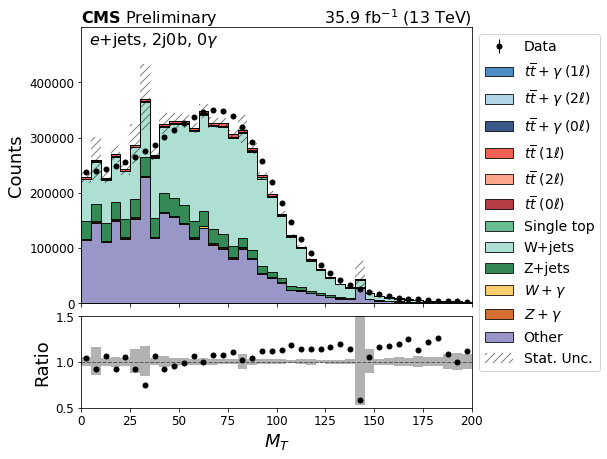

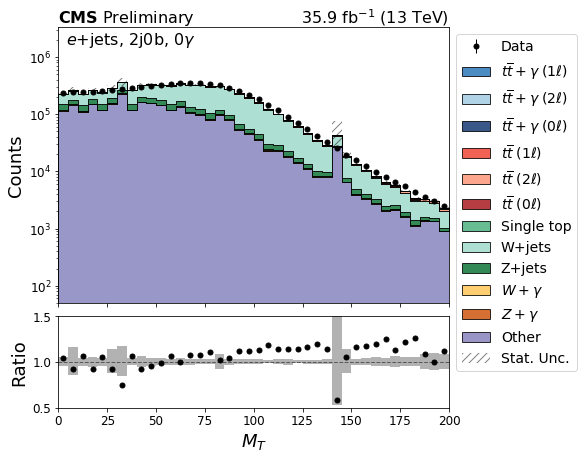

In [10]:
h = output['WtransMass'].integrate('lepton','electron').group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder)
h = h.rebin('MT',hist.Bin('MT','$M_{T}$',np.arange(0,200.1,5)))
h = h.integrate('nPho',0).integrate('nJet',2).integrate('nBJet',0)
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['WtransMass'].integrate('lepton','electron').group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData)
hData = hData.rebin('MT',hist.Bin('MT','$M_{T}$',np.arange(0,200.1,5)))
hData = hData.integrate('nPho',0).integrate('nJet',2).integrate('nBJet',0)


test = plotWithRatio(h,hData,'dataset', lumi=lumi, 
                     extraText="$e$+jets, 2j0b, 0$\gamma$",colors=colors
                    )

test = plotWithRatio(h,hData,'dataset', lumi=lumi, 
                     extraText="$e$+jets, 2j0b, 0$\gamma$",colors=colors,logY=True,
                     xRange=(0,None),
                     yRange=(50,3e6),
                    )

/uscms/home/dnoonan/.local/lib/python3.6/site-packages/coffea/hist/hist_tools.py:337: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f165bcaca90>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/uscms_data/d2/dnoonan/13TeV_TTGamma/NanoAODTest/Coffea_TTGamma/utils/plotting.py:129: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0,ax.get_ylim()[1]*1.1)


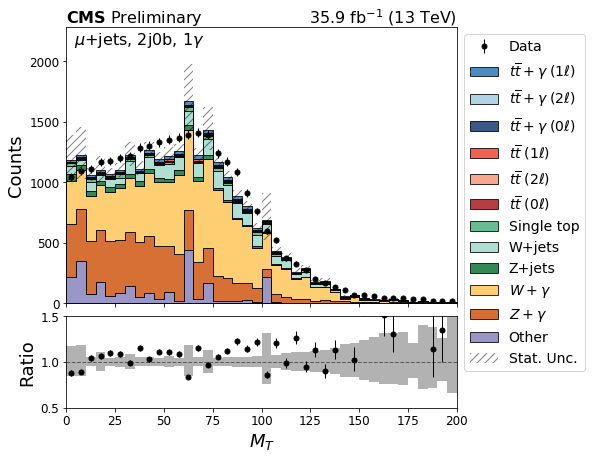

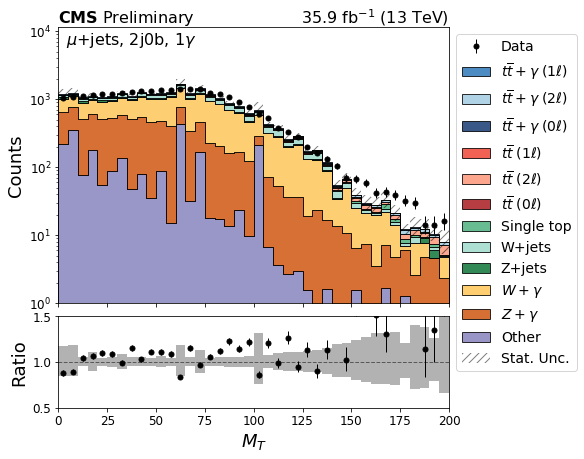

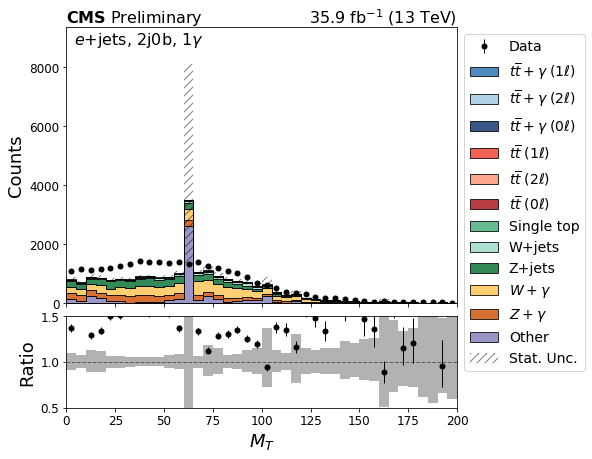

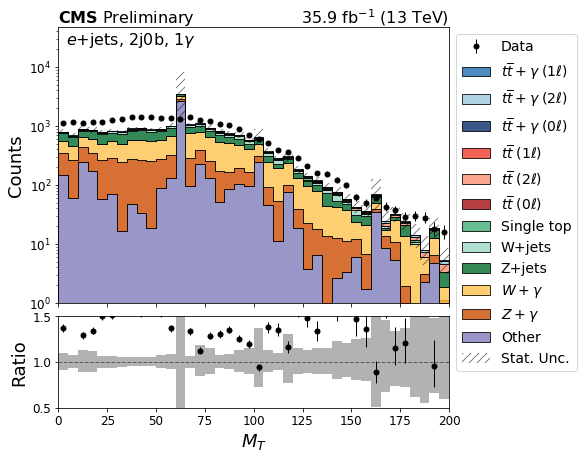

In [11]:
h = output['WtransMass'].integrate('lepton','muon').group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder)
h = h.rebin('MT',hist.Bin('MT','$M_{T}$',np.arange(0,200.1,5)))
h = h.integrate('nPho',1).integrate('nJet',2).integrate('nBJet',0)
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['WtransMass'].integrate('lepton','muon').group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData)
hData = hData.rebin('MT',hist.Bin('MT','$M_{T}$',np.arange(0,200.1,5)))
hData = hData.integrate('nPho',1).integrate('nJet',2).integrate('nBJet',0)


test = plotWithRatio(h,hData,'dataset', lumi=lumi, 
                     extraText="$\mu$+jets, 2j0b, 1$\gamma$",colors=colors
                    )

test = plotWithRatio(h,hData,'dataset', lumi=lumi, 
                     extraText="$\mu$+jets, 2j0b, 1$\gamma$",colors=colors,logY=True,
#                      xRange=(0,None),
#                      yRange=(50,3e6),
                    )



h = output['WtransMass'].integrate('lepton','electron').group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder)
h = h.rebin('MT',hist.Bin('MT','$M_{T}$',np.arange(0,200.1,5)))
h = h.integrate('nPho',1).integrate('nJet',2).integrate('nBJet',0)
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['WtransMass'].integrate('lepton','electron').group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData)
hData = hData.rebin('MT',hist.Bin('MT','$M_{T}$',np.arange(0,200.1,5)))
hData = hData.integrate('nPho',1).integrate('nJet',2).integrate('nBJet',0)


test = plotWithRatio(h,hData,'dataset', lumi=lumi, 
                     extraText="$e$+jets, 2j0b, 1$\gamma$",colors=colors
                    )

test = plotWithRatio(h,hData,'dataset', lumi=lumi, 
                     extraText="$e$+jets, 2j0b, 1$\gamma$",colors=colors,logY=True,
#                      xRange=(0,None),
#                      yRange=(50,3e6),
                    )

/uscms/home/dnoonan/.local/lib/python3.6/site-packages/coffea/hist/hist_tools.py:337: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f165bcaca90>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/uscms/home/dnoonan/.local/lib/python3.6/site-packages/coffea/hist/plot.py:340: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/dnoonan/.local/lib/python3.6/site-packages/coffea/hist/plot.py:347: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/uscms/home/dnoonan/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:871: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
/uscms/home/dnoonan/.local/lib/python3.6/site-packages/coffea/hist/plot.py:361: RuntimeWarning: invalid value encountered in true_divide
  denom_un

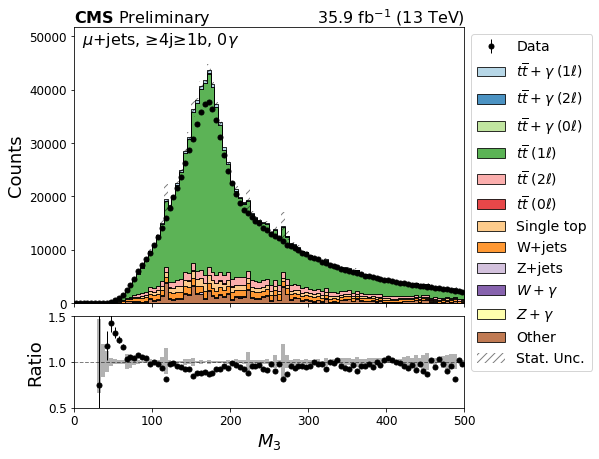

In [12]:
h = output['M3'].integrate('lepton','muon').group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder)
h = h.rebin('M3',hist.Bin('M3','$M_{3}$',np.arange(0,500.1,5)))
h = h.integrate('nPho',0).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['M3'].integrate('lepton','muon').group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData)
hData = hData.rebin('M3',hist.Bin('M3','$M_{3}$',np.arange(0,500.1,5)))
hData = hData.integrate('nPho',0).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))


test = plotWithRatio(h,hData,'dataset', lumi=lumi, extraText="$\mu$+jets, ≥4j≥1b, 0$\gamma$")

/uscms/home/dnoonan/.local/lib/python3.6/site-packages/coffea/hist/hist_tools.py:337: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f165bcaca90>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/uscms/home/dnoonan/.local/lib/python3.6/site-packages/coffea/hist/plot.py:340: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/dnoonan/.local/lib/python3.6/site-packages/coffea/hist/plot.py:347: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/uscms/home/dnoonan/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:871: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
/uscms/home/dnoonan/.local/lib/python3.6/site-packages/coffea/hist/plot.py:361: RuntimeWarning: invalid value encountered in true_divide
  denom_un

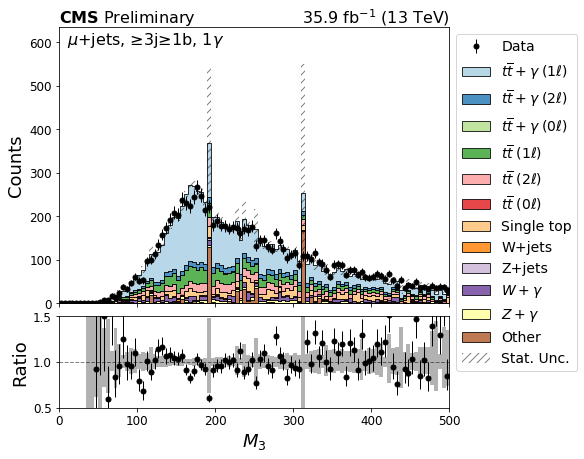

In [13]:
h = output['M3'].integrate('lepton','muon').group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder)
h = h.rebin('M3',hist.Bin('M3','$M_{3}$',np.arange(0,500.1,5)))
h = h.integrate('nPho',1).integrate('nJet',slice(3,None)).integrate('nBJet',slice(1,None))
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['M3'].integrate('lepton','muon').group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData)
hData = hData.rebin('M3',hist.Bin('M3','$M_{3}$',np.arange(0,500.1,5)))
hData = hData.integrate('nPho',1).integrate('nJet',slice(3,None)).integrate('nBJet',slice(1,None))


test = plotWithRatio(h,hData,'dataset', lumi=lumi, extraText="$\mu$+jets, ≥3j≥1b, 1$\gamma$")

/uscms/home/dnoonan/.local/lib/python3.6/site-packages/coffea/hist/hist_tools.py:337: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f165bcaca90>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


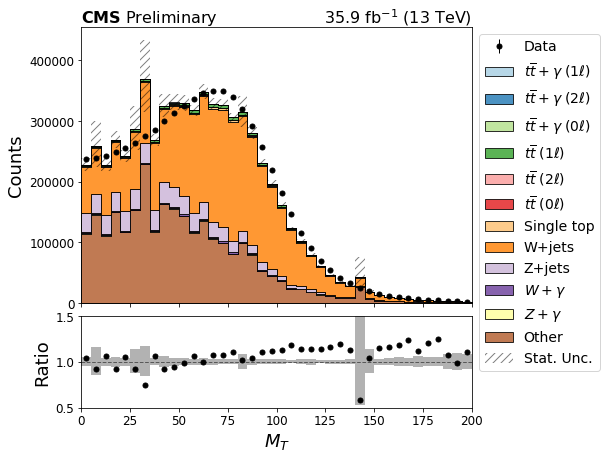

In [14]:

h = output['WtransMass'].integrate('lepton','electron').group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder)
h = h.rebin('MT',hist.Bin('MT','$M_{T}$',np.arange(0,200.1,5)))
h = h.integrate('nPho',0).integrate('nJet',2).integrate('nBJet',0)
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['WtransMass'].integrate('lepton','electron').group('dataset',hist.Cat(r'dataset',r'Samples'),categoryDataEle)
hData = hData.rebin('MT',hist.Bin('MT','$M_{T}$',np.arange(0,200.1,5)))
hData = hData.integrate('nPho',0).integrate('nJet',2).integrate('nBJet',0)


plotWithRatio(h,hData,'dataset', lumi=lumi)

/uscms/home/dnoonan/.local/lib/python3.6/site-packages/coffea/hist/hist_tools.py:337: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f165bcaca90>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)


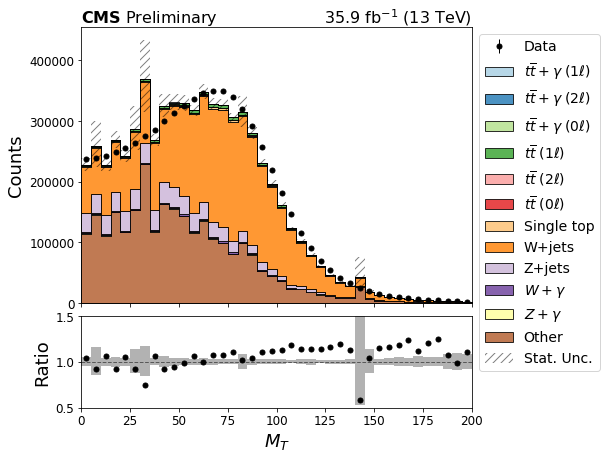

In [15]:

h = output['WtransMass'].integrate('lepton','electron').group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder)
h = h.rebin('MT',hist.Bin('MT','$M_{T}$',np.arange(0,200.1,5)))
h = h.integrate('nPho',0).integrate('nJet',2).integrate('nBJet',0)
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['WtransMass'].integrate('lepton','electron').group('dataset',hist.Cat(r'dataset',r'Samples'),categoryDataEle)
hData = hData.rebin('MT',hist.Bin('MT','$M_{T}$',np.arange(0,200.1,5)))
hData = hData.integrate('nPho',0).integrate('nJet',2).integrate('nBJet',0)


plotWithRatio(h,hData,'dataset', lumi=lumi)

/uscms/home/dnoonan/.local/lib/python3.6/site-packages/coffea/hist/hist_tools.py:337: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f165bcaca90>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/uscms/home/dnoonan/.local/lib/python3.6/site-packages/coffea/hist/plot.py:340: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/dnoonan/.local/lib/python3.6/site-packages/coffea/hist/plot.py:347: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/uscms/home/dnoonan/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:871: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
/uscms/home/dnoonan/.local/lib/python3.6/site-packages/coffea/hist/plot.py:361: RuntimeWarning: invalid value encountered in true_divide
  denom_un

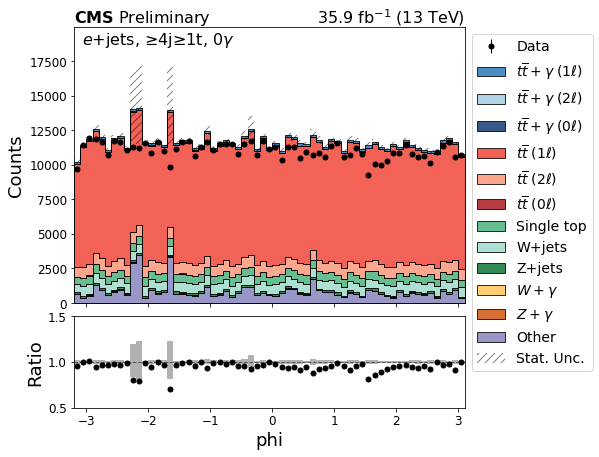

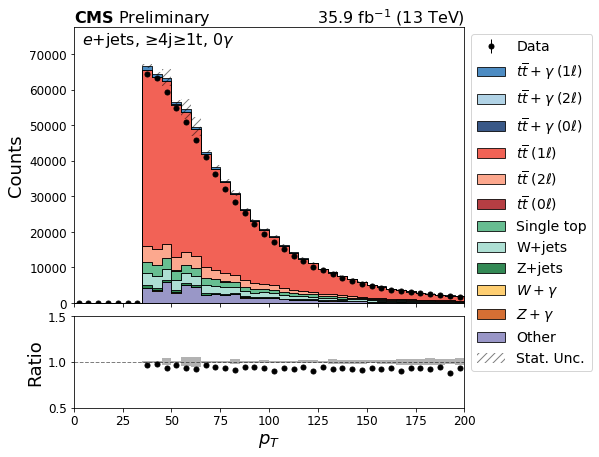

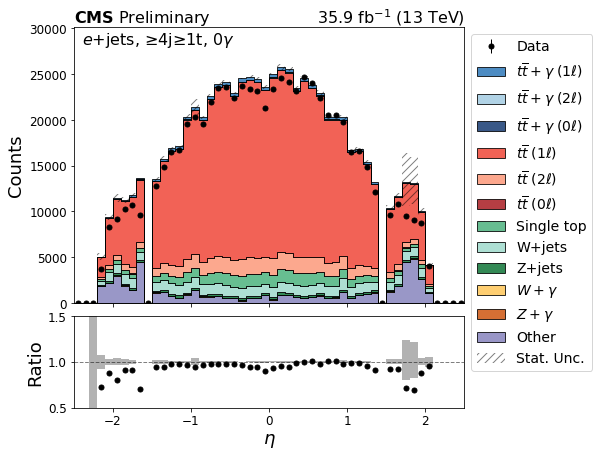

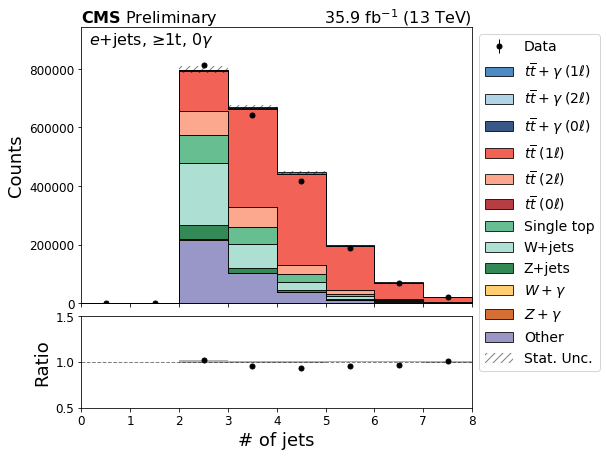

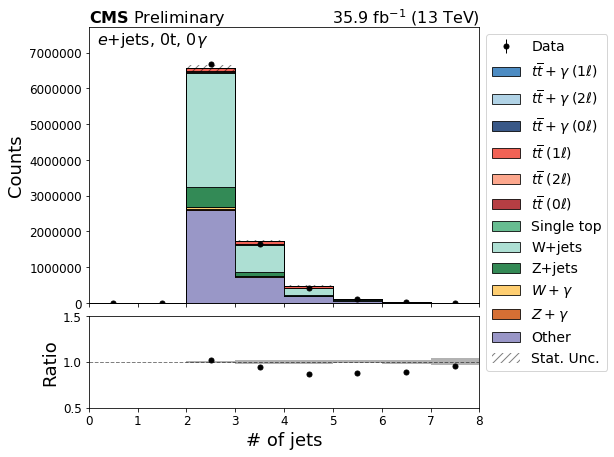

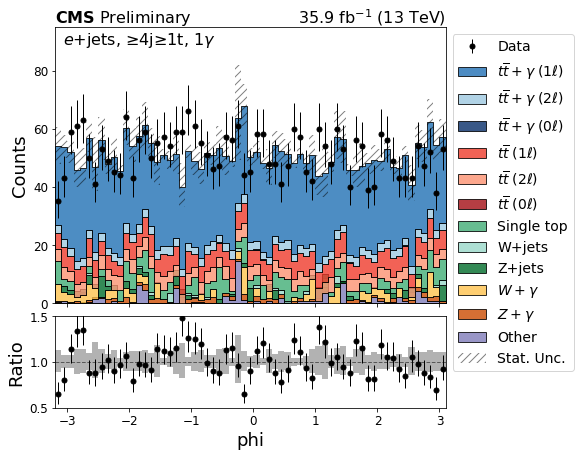

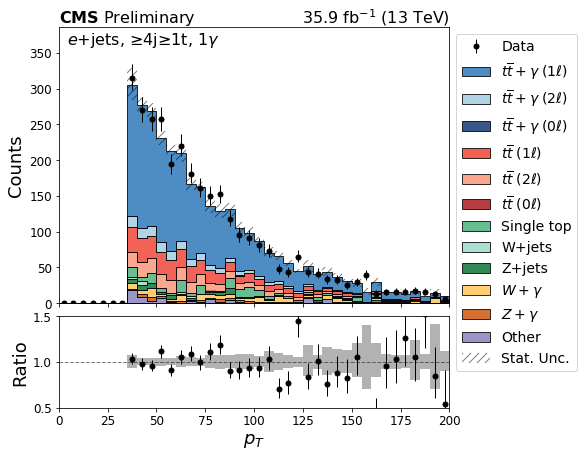

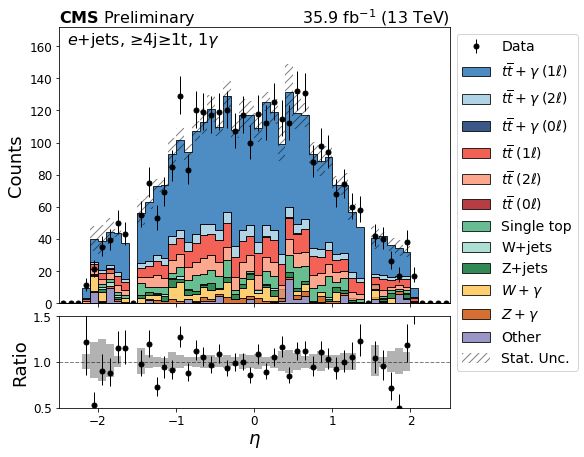

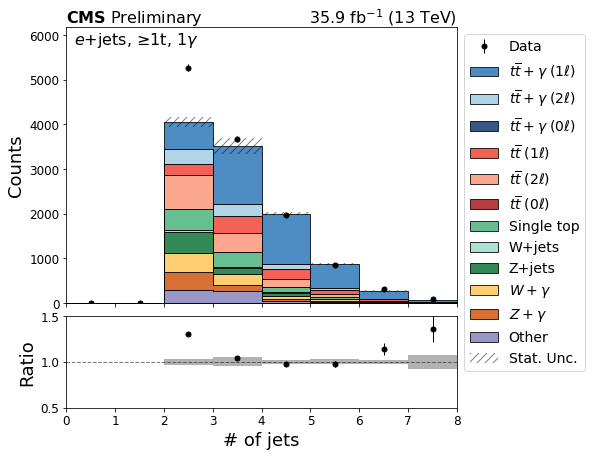

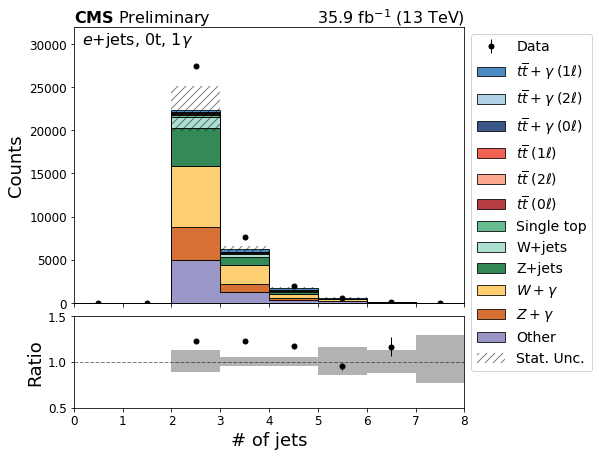

In [16]:
h = output['elePhi'].group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder).rebin('phi',hist.Bin('phi','phi',np.arange(-3.2,3.2,0.1)))
h=h.integrate('nPho',0).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['elePhi'].group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData).rebin('phi',hist.Bin('phi','phi',np.arange(-3.2,3.2,0.1)))
hData=hData.integrate('nPho',0).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))

plotWithRatio(h,hData,'dataset', lumi=lumi,
              colors=colors,extraText="$e$+jets, ≥4j≥1t, 0$\gamma$")

h = output['elePt'].group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder).rebin('pt',hist.Bin('pt','$p_{T}$',np.arange(0,200.1,5)))
h=h.integrate('nPho',0).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['elePt'].group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData).rebin('pt',hist.Bin('pt','$p_{T}$',np.arange(0,200.1,5)))
hData=hData.integrate('nPho',0).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))

plotWithRatio(h,hData,'dataset', lumi=lumi,
              colors=colors,extraText="$e$+jets, ≥4j≥1t, 0$\gamma$")


h = output['eleEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder).rebin('eta',hist.Bin('eta','$\eta$',np.arange(-2.5,2.501,.1)))
h=h.integrate('nPho',0).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['eleEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData).rebin('eta',hist.Bin('eta','$\eta$',np.arange(-2.5,2.501,.1)))
hData=hData.integrate('nPho',0).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))

plotWithRatio(h,hData,'dataset', lumi=lumi,
              colors=colors,extraText="$e$+jets, ≥4j≥1t, 0$\gamma$")


h = output['eleEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder).sum('eta')
h=h.integrate('nPho',0).integrate('nBJet',slice(1,None))
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['eleEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData).sum('eta')
hData=hData.integrate('nPho',0).integrate('nBJet',slice(1,None))

plotWithRatio(h,hData,'dataset', lumi=lumi,
              colors=colors,extraText="$e$+jets, ≥1t, 0$\gamma$")

h = output['eleEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder).sum('eta')
h=h.integrate('nPho',0).integrate('nBJet',0)
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['eleEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData).sum('eta')
hData=hData.integrate('nPho',0).integrate('nBJet',0)

plotWithRatio(h,hData,'dataset', lumi=lumi,
              colors=colors,extraText="$e$+jets, 0t, 0$\gamma$")


h = output['elePhi'].group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder).rebin('phi',hist.Bin('phi','phi',np.arange(-3.2,3.2,0.1)))
h=h.integrate('nPho',1).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['elePhi'].group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData).rebin('phi',hist.Bin('phi','phi',np.arange(-3.2,3.2,0.1)))
hData=hData.integrate('nPho',1).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))

plotWithRatio(h,hData,'dataset', lumi=lumi,
              colors=colors,extraText="$e$+jets, ≥4j≥1t, 1$\gamma$")

h = output['elePt'].group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder).rebin('pt',hist.Bin('pt','$p_{T}$',np.arange(0,200.1,5)))
h=h.integrate('nPho',1).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['elePt'].group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData).rebin('pt',hist.Bin('pt','$p_{T}$',np.arange(0,200.1,5)))
hData=hData.integrate('nPho',1).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))

plotWithRatio(h,hData,'dataset', lumi=lumi,
              colors=colors,extraText="$e$+jets, ≥4j≥1t, 1$\gamma$")


h = output['eleEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder).rebin('eta',hist.Bin('eta','$\eta$',np.arange(-2.5,2.501,.1)))
h=h.integrate('nPho',1).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['eleEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData).rebin('eta',hist.Bin('eta','$\eta$',np.arange(-2.5,2.501,.1)))
hData=hData.integrate('nPho',1).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))

plotWithRatio(h,hData,'dataset', lumi=lumi,
              colors=colors,extraText="$e$+jets, ≥4j≥1t, 1$\gamma$")

h = output['eleEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder).sum('eta')
h=h.integrate('nPho',1).integrate('nBJet',slice(1,None))
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['eleEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData).sum('eta')
hData=hData.integrate('nPho',1).integrate('nBJet',slice(1,None))

plotWithRatio(h,hData,'dataset', lumi=lumi,
              colors=colors,extraText="$e$+jets, ≥1t, 1$\gamma$")

h = output['eleEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder).sum('eta')
h=h.integrate('nPho',1).integrate('nBJet',0)
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['eleEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData).sum('eta')
hData=hData.integrate('nPho',1).integrate('nBJet',0)

plotWithRatio(h,hData,'dataset', lumi=lumi,
              colors=colors,extraText="$e$+jets, 0t, 1$\gamma$")

/uscms/home/dnoonan/.local/lib/python3.6/site-packages/coffea/hist/hist_tools.py:337: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f165bcaca90>
  warnings.warn("Not all requested indices present in %r" % self, RuntimeWarning)
/uscms/home/dnoonan/.local/lib/python3.6/site-packages/coffea/hist/plot.py:340: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/uscms/home/dnoonan/.local/lib/python3.6/site-packages/coffea/hist/plot.py:347: RuntimeWarning: invalid value encountered in true_divide
  rsumw_err = np.abs(poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw)
/uscms/home/dnoonan/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:871: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))
/uscms/home/dnoonan/.local/lib/python3.6/site-packages/coffea/hist/plot.py:361: RuntimeWarning: invalid value encountered in true_divide
  denom_un

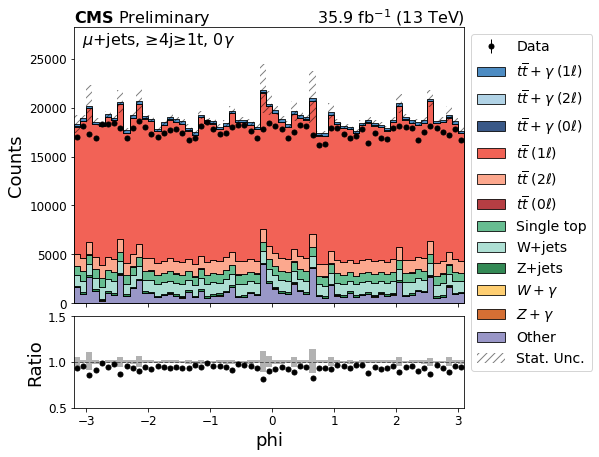

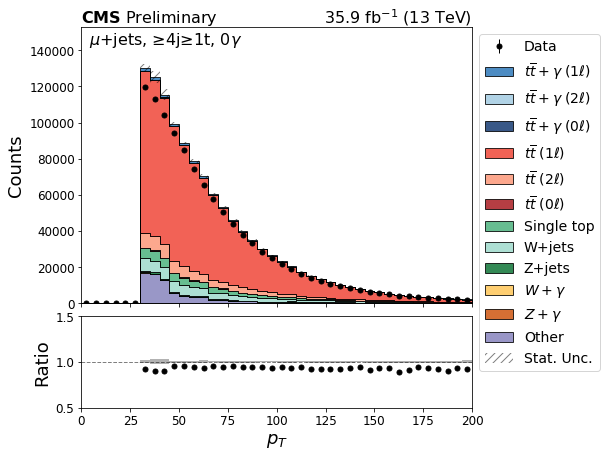

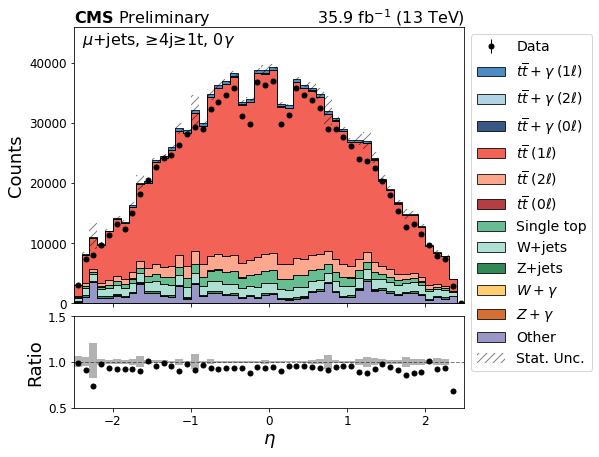

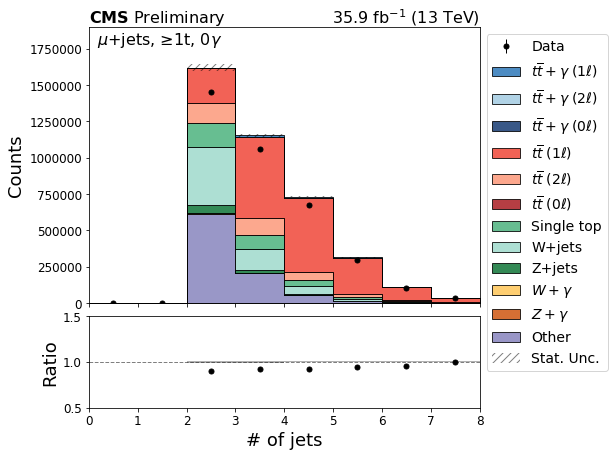

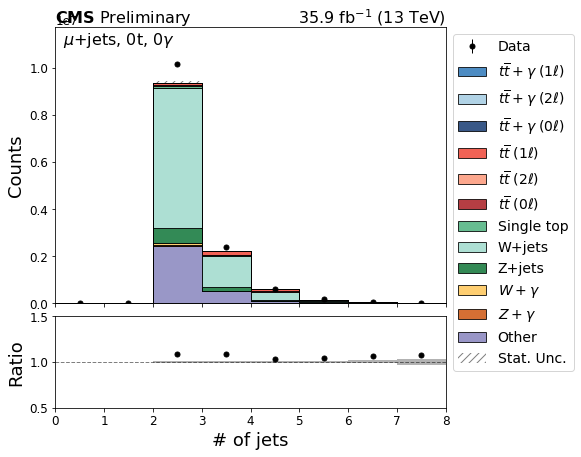

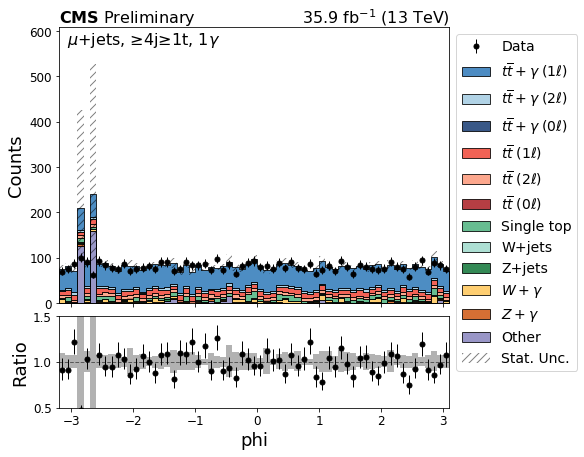

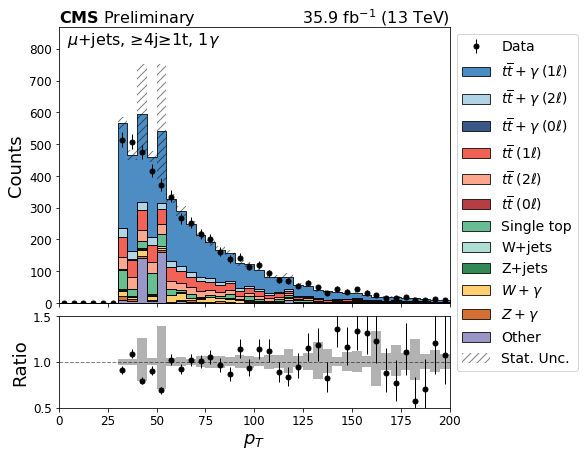

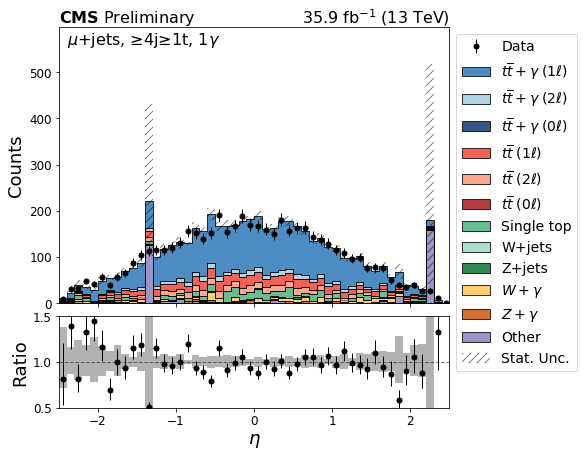

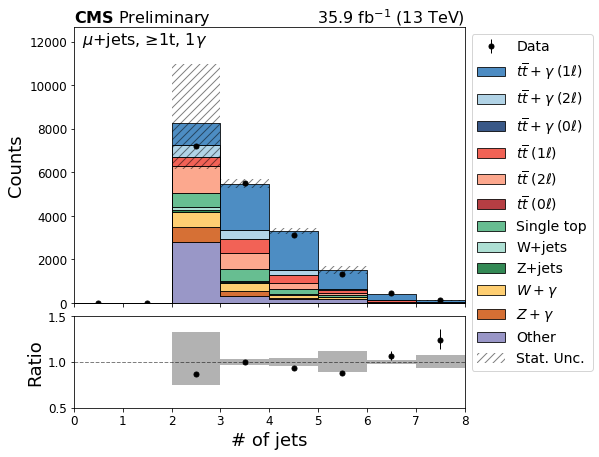

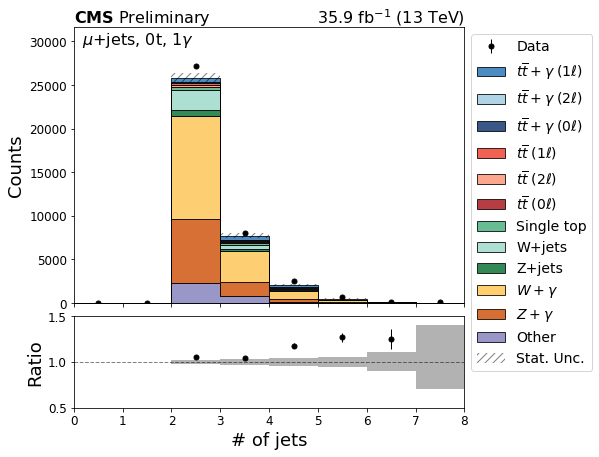

In [17]:
h = output['muPhi'].group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder).rebin('phi',hist.Bin('phi','phi',np.arange(-3.2,3.2,0.1)))
h=h.integrate('nPho',0).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['muPhi'].group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData).rebin('phi',hist.Bin('phi','phi',np.arange(-3.2,3.2,0.1)))
hData=hData.integrate('nPho',0).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))

plotWithRatio(h,hData,'dataset', lumi=lumi,
              colors=colors,extraText="$\mu$+jets, ≥4j≥1t, 0$\gamma$")

h = output['muPt'].group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder).rebin('pt',hist.Bin('pt','$p_{T}$',np.arange(0,200.1,5)))
h=h.integrate('nPho',0).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['muPt'].group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData).rebin('pt',hist.Bin('pt','$p_{T}$',np.arange(0,200.1,5)))
hData=hData.integrate('nPho',0).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))

plotWithRatio(h,hData,'dataset', lumi=lumi,
              colors=colors,extraText="$\mu$+jets, ≥4j≥1t, 0$\gamma$")


h = output['muEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder).rebin('eta',hist.Bin('eta','$\eta$',np.arange(-2.5,2.501,.1)))
h=h.integrate('nPho',0).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['muEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData).rebin('eta',hist.Bin('eta','$\eta$',np.arange(-2.5,2.501,.1)))
hData=hData.integrate('nPho',0).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))

plotWithRatio(h,hData,'dataset', lumi=lumi,
              colors=colors,extraText="$\mu$+jets, ≥4j≥1t, 0$\gamma$")


h = output['muEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder).sum('eta')
h=h.integrate('nPho',0).integrate('nBJet',slice(1,None))
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['muEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData).sum('eta')
hData=hData.integrate('nPho',0).integrate('nBJet',slice(1,None))

plotWithRatio(h,hData,'dataset', lumi=lumi,
              colors=colors,extraText="$\mu$+jets, ≥1t, 0$\gamma$")

h = output['muEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder).sum('eta')
h=h.integrate('nPho',0).integrate('nBJet',0)
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['muEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData).sum('eta')
hData=hData.integrate('nPho',0).integrate('nBJet',0)

plotWithRatio(h,hData,'dataset', lumi=lumi,
              colors=colors,extraText="$\mu$+jets, 0t, 0$\gamma$")


h = output['muPhi'].group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder).rebin('phi',hist.Bin('phi','phi',np.arange(-3.2,3.2,0.1)))
h=h.integrate('nPho',1).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['muPhi'].group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData).rebin('phi',hist.Bin('phi','phi',np.arange(-3.2,3.2,0.1)))
hData=hData.integrate('nPho',1).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))

plotWithRatio(h,hData,'dataset', lumi=lumi,
              colors=colors,extraText="$\mu$+jets, ≥4j≥1t, 1$\gamma$")

h = output['muPt'].group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder).rebin('pt',hist.Bin('pt','$p_{T}$',np.arange(0,200.1,5)))
h=h.integrate('nPho',1).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['muPt'].group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData).rebin('pt',hist.Bin('pt','$p_{T}$',np.arange(0,200.1,5)))
hData=hData.integrate('nPho',1).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))

plotWithRatio(h,hData,'dataset', lumi=lumi,
              colors=colors,extraText="$\mu$+jets, ≥4j≥1t, 1$\gamma$")


h = output['muEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder).rebin('eta',hist.Bin('eta','$\eta$',np.arange(-2.5,2.501,.1)))
h=h.integrate('nPho',1).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['muEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData).rebin('eta',hist.Bin('eta','$\eta$',np.arange(-2.5,2.501,.1)))
hData=hData.integrate('nPho',1).integrate('nJet',slice(4,None)).integrate('nBJet',slice(1,None))

plotWithRatio(h,hData,'dataset', lumi=lumi,
              colors=colors,extraText="$\mu$+jets, ≥4j≥1t, 1$\gamma$")

h = output['muEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder).sum('eta')
h=h.integrate('nPho',1).integrate('nBJet',slice(1,None))
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['muEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData).sum('eta')
hData=hData.integrate('nPho',1).integrate('nBJet',slice(1,None))

plotWithRatio(h,hData,'dataset', lumi=lumi,
              colors=colors,extraText="$\mu$+jets, ≥1t, 1$\gamma$")

h = output['muEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),datasetOrder).sum('eta')
h=h.integrate('nPho',1).integrate('nBJet',0)
h._axes[0]._sorted = list(datasetOrder.keys())
hData = outputData['muEta'].group('dataset',hist.Cat(r'dataset',r'Samples'),categoryData).sum('eta')
hData=hData.integrate('nPho',1).integrate('nBJet',0)

plotWithRatio(h,hData,'dataset', lumi=lumi,
              colors=colors,extraText="$\mu$+jets, 0t, 1$\gamma$")